## Model for predicting house prices
This notebook documents the process of building, training, and evaluating a machine learning model for predicting house prices using various input features.

In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import shap
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

### Load and Prepare Data
Read the cleaned training data and create a log-transformed target variable for modeling.

In [318]:
df = pd.read_csv('../Data/cleaned_train.csv')
df['SalePrice_Log'] = np.log(df['SalePrice'])

### Select Numeric and Categorical Features
Identify which columns are numeric and which are categorical for preprocessing.

In [319]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(['SalePrice', 'SalePrice_Log'], axis=1).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

### Define Preprocessing Pipelines
Set up separate pipelines for numeric and categorical data, including imputation and scaling/encoding.

In [320]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

### Create Column Transformer
Combine numeric and categorical preprocessing pipelines into a single column transformer.

In [321]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features), 
    ('cat', categorical_transformer, categorical_features)    
])


### Split Features and Target Variable
Separate the features (X) from the target variable (y) for modeling.

In [322]:
X = df.drop(['SalePrice', 'SalePrice_Log'], axis=1)
y = df['SalePrice_Log']

### Split Data into Training and Test Sets
Divide the dataset into training and test sets to evaluate model performance.

In [323]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Define Models to Compare
Set up a dictionary of different regression models to evaluate.

In [324]:
models = {
    'Ridge Regression'  : Ridge(alpha=10),
    'Lasso Regression'  : Lasso(alpha=0.01),
    'Random Forest'     : RandomForestRegressor(n_estimators=100, random_state=42),
    'XG Boost'          : XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

}

### Train and Evaluate All Models
Train each model using a pipeline and evaluate performance using RMSE and R2 metrics.

In [325]:
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred_log = pipeline.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_test_actual = np.expm1(y_test)
    
    rmse = mean_squared_error(y_test_actual, y_pred, squared=False)
    r2_train = pipeline.score(X_train, y_train)
    r2_test = r2_score(y_test_actual, y_pred)
    
    print(f"{name} have RMSE: {rmse:.2f}, R2 Train: {r2_train:.4f}, R2 Test: {r2_test:.4f}")


c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Ridge Regression have RMSE: 24883.30, R2 Train: 0.9231, R2 Test: 0.9193
Lasso Regression have RMSE: 31470.64, R2 Train: 0.8550, R2 Test: 0.8709


c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Random Forest have RMSE: 29522.13, R2 Train: 0.9812, R2 Test: 0.8864
XG Boost have RMSE: 26821.94, R2 Train: 0.9948, R2 Test: 0.9062
XG Boost have RMSE: 26821.94, R2 Train: 0.9948, R2 Test: 0.9062


c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Save Model Comparison Results and Plot
Save the RMSE/R2 results for each model to a table and plot a bar chart for comparison.

In [326]:
results = []
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred_log = pipeline.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_test_actual = np.expm1(y_test)
    rmse = mean_squared_error(y_test_actual, y_pred, squared=False)
    r2_train = pipeline.score(X_train, y_train)
    r2_test = r2_score(y_test_actual, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R2_Train': r2_train, 'R2_Test': r2_test})
results_df = pd.DataFrame(results)

display(results_df)

results_df.to_csv('../Results/model_comparison_results.csv', index=False)

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

,Model,RMSE,R2_Train,R2_Test
0,Ridge Regression,24883.296809,0.923135,0.919276
1,Lasso Regression,31470.637477,0.855023,0.870879
2,Random Forest,29522.125314,0.981189,0.886373
3,XG Boost,26821.944862,0.994764,0.906208


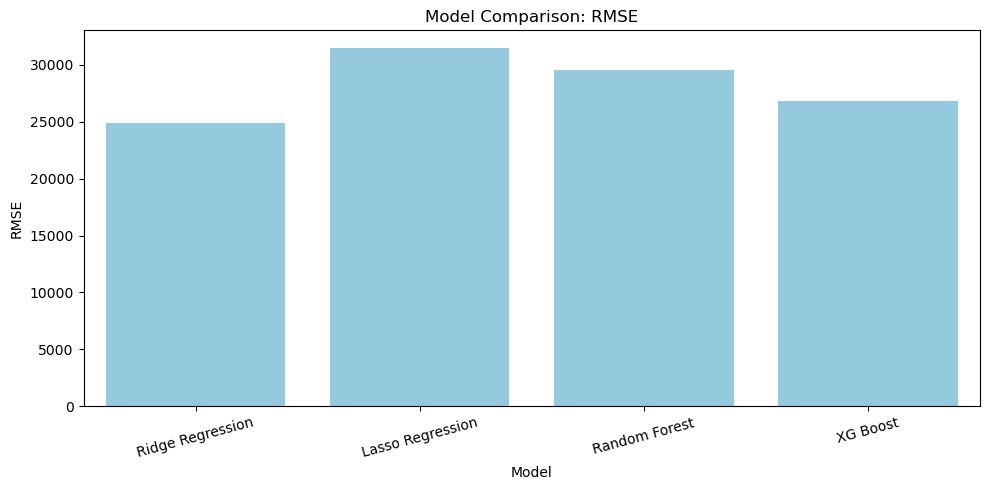

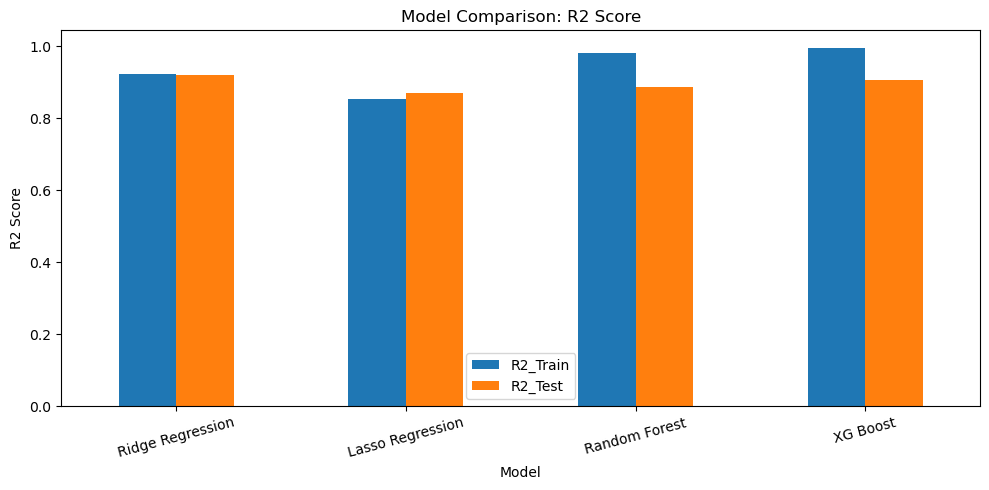

In [327]:
fig, ax1 = plt.subplots(figsize=(10,5))
sns.barplot(x='Model', y='RMSE', data=results_df, ax=ax1, color='skyblue')
ax1.set_ylabel('RMSE')
ax1.set_title('Model Comparison: RMSE')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('../Results/model_comparison_rmse.png')
plt.show()

fig, ax2 = plt.subplots(figsize=(10,5))
results_df.plot(x='Model', y=['R2_Train', 'R2_Test'], kind='bar', ax=ax2)
ax2.set_ylabel('R2 Score')
ax2.set_title('Model Comparison: R2 Score')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('../Results/model_comparison_r2.png')
plt.show()

### Why Choose Ridge Regression?
Although Random Forest and XGBoost models achieve higher R2 scores on the training set, Ridge Regression is selected for further analysis because it has the lowest RMSE on the test set and the smallest difference between R2 on the training and test sets. This indicates that Ridge Regression generalizes better and is less likely to overfit compared to the more complex models, making it a more robust choice for predicting house prices on unseen data.

### Build Ridge Regression Pipeline
Create a pipeline specifically for Ridge regression with preprocessing steps.

In [328]:
pipeline_Ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=10))
])

### Fit Ridge Regression and Predict
Train the Ridge regression pipeline and generate predictions on the test set.

In [329]:
pipeline_Ridge.fit(X_train, y_train)
y_pred_rid = pipeline_Ridge.predict(X_test)
y_pred = np.expm1(y_pred_rid)
y_test_actual = np.expm1(y_test)

### Plot Residuals of Ridge Regression
Visualize the residuals to assess the model's errors and check for patterns.

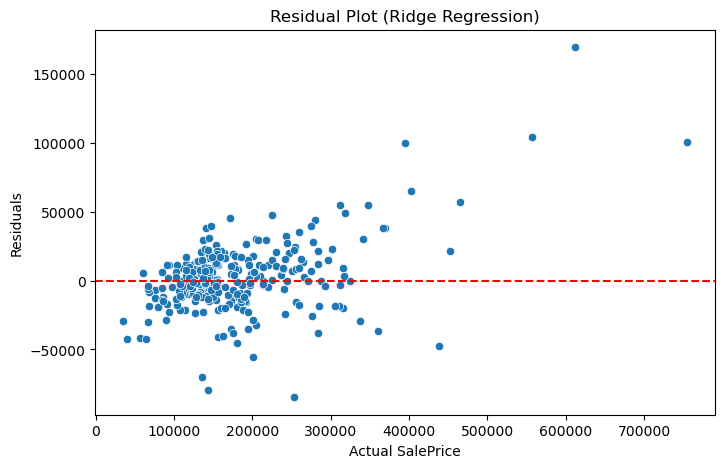

In [330]:
residuals = y_test_actual - y_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test_actual, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Residuals')
plt.title('Residual Plot (Ridge Regression)')
plt.savefig('../Results/residual_plot_ridge.png')
plt.show()

### Plot Actual vs Predicted Values (Ridge Regression)
Visualize the relationship between actual and predicted house prices to assess model fit.

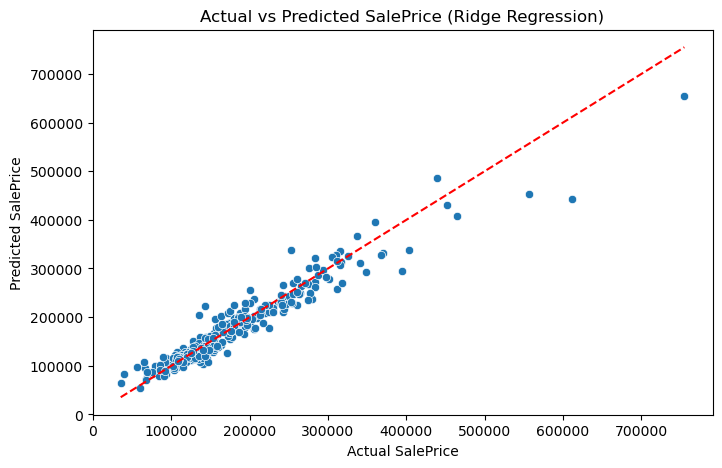

In [331]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test_actual, y=y_pred)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice (Ridge Regression)')
plt.savefig('../Results/actual_vs_predicted_ridge.png')
plt.show()


### SHAP Analysis
Use SHAP (SHapley Additive exPlanations) to interpret the feature importance and understand how each feature impacts the Ridge Regression model's predictions.

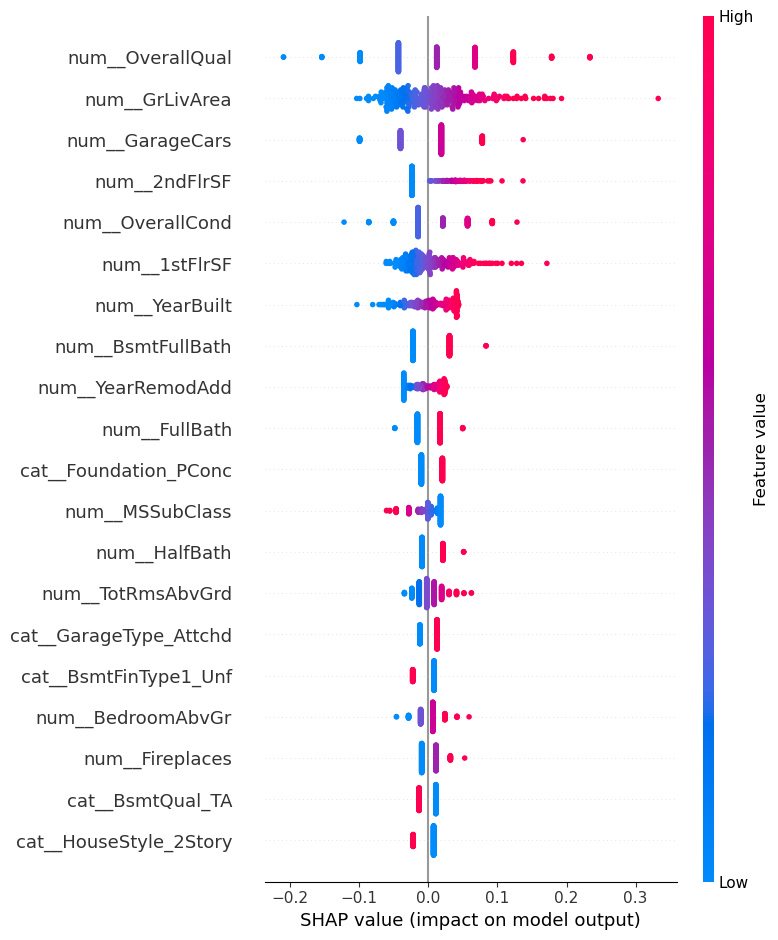

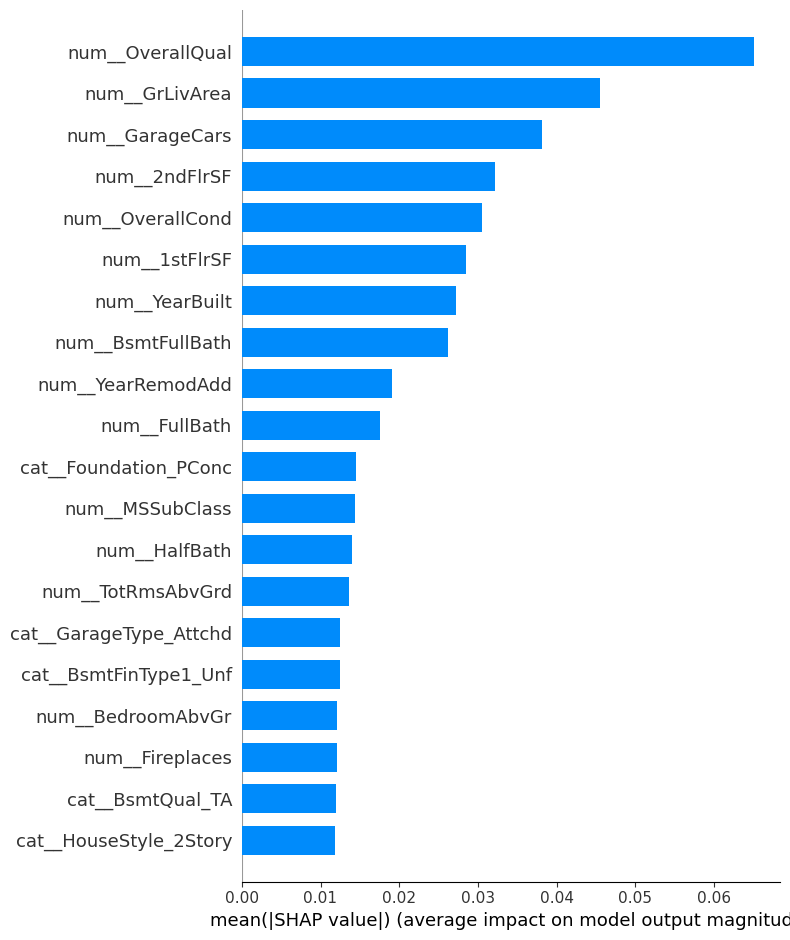

In [332]:
# Prepare data for SHAP (after preprocessing)
X_test_transformed = pipeline_Ridge.named_steps['preprocessor'].transform(X_test)

# Create SHAP explainer for linear models
explainer = shap.LinearExplainer(pipeline_Ridge.named_steps['regressor'], X_test_transformed)
shap_values = explainer.shap_values(X_test_transformed)

# SHAP summary plot
shap.summary_plot(shap_values, X_test_transformed, feature_names=pipeline_Ridge.named_steps['preprocessor'].get_feature_names_out(), show=False)
plt.tight_layout()
plt.savefig('../Results/shap_summary_ridge.png')
plt.show()

# SHAP bar plot (feature importance)
shap.summary_plot(shap_values, X_test_transformed, feature_names=pipeline_Ridge.named_steps['preprocessor'].get_feature_names_out(), plot_type='bar', show=False)
plt.tight_layout()
plt.savefig('../Results/shap_bar_ridge.png')
plt.show()

### Save the Trained Ridge Regression Model
Save the trained Ridge Regression pipeline to the Results folder for future use or deployment.

In [335]:
joblib.dump(pipeline_Ridge, '../Results/ridge_regression_pipeline.joblib')

['../Results/ridge_regression_pipeline.joblib']